This notebook reads in `.h5` files exported from the `mit_stem` non-linear drift correction aquistition software, and runs the non-linear drift correction algorithm developed by Ophus, Ciston, and Nelson (DOI: [10.1016/j.ultramic.2015.12.002](doi.org/10.1016/j.ultramic.2015.12.002)).  The python port of the algorithm was developed by Timothy Poon in conjunction with Colin Ophus and Alex Rakowski, and is available [here (GitHub)](https://github.com/ptim0626/scanning-drift-corr).  The aquisition software was developed by the LeBeau group at MIT, and modified by Stephen Funni at CMU to export additional metadata.

We begin by setting some general options and choosing a directory to search for `.h5` files:

In [165]:
from importlib import reload
from copy import deepcopy
from json import loads
from re import search
from h5py import File
import matplotlib.pyplot as plt
from numpy import array, isin, rot90, save, load, stack, uint16
from scanning_drift_corr.api import SPmerge01linear, SPmerge02, SPmerge03
from abtem_scripts import graphical
reload(graphical)
import SingleOrigin as so
reload(so)

<module 'SingleOrigin' from 'C:\\Users\\charles\\Documents\\GitHub\\SingleOrigin\\__init__.py'>

In [166]:
get_dpc_images = False  # Whether to search for DPC a-c and b-d scans in the .h5 file
num_frames_to_use = 2  # The number of frames to use in drift correction (usually either 2 or 4)
grd = 'NOGRD'  # Default export filename component if no scan calibration used

In [167]:
source_folder = graphical.gui_get_path(is_file=False)
# %% Get all .h5 files
file_list = sorted(source_folder.glob("*.h5"))  # Skips subdirectories; use the glob "**/*.h5" to include subdirectories
print([f"{i}: {f.stem}" for i, f in enumerate(file_list)])

['0: 04-04-2023_14.41.00_HAADF', '1: 04-04-2023_14.41.27_HAADF']


If you don't see the file(s) you're looking for in the list above, ensure you've selected the right directory and that the files have the ".h5" suffix.

The following cell selects a particular file from the list above to perform drift correction on:

In [168]:
filepath = file_list[0]

This cell extracts the needed information from the `.h5` file, after which it is closed, and then does a bit of work to get everything into the correct form to be processed by the drift correction algorithm:

In [169]:
with File(filepath.resolve(strict=True), 'r') as f:
    # Extract scan angles, and then either take the first few set by num_frames_to_use, or warn that there are fewer available frames than asked for
    scanAngles = array(f['Frame Rotation'])
    if num_frames_to_use <= scanAngles.shape[0]:
        scanAngles = scanAngles[:num_frames_to_use]
    else:
        raise ValueError(f"Fewer scan frames available ({scanAngles.shape[0]}) than requested ({num_frames_to_use}): reduce `num_frames_to_use`")

    # Extract the HAADF scans and, if desired and available, extract the DPC scans as well
    haadfs = array(f['Images']['HAADF'][search(r"'(.*)'", repr(str(f['Images']['HAADF'].keys()))).group(1)])
    if get_dpc_images:
        if isin('Segment1 - Segment3', list(f['Images'].keys())):
            dpc_found = True
            # Load DPC difference signals
            dpc_ac = array(f['Images']['Segment1 - Segment3']
                              [search(r"'(.*)'", repr(str(f['Images']['Segment1 - Segment3'].keys())))
                              .group(1)])
            dpc_bd = array(f['Images']['Segment2 - Segment4']
                           [search(r"'(.*)'", repr(str(f['Images']['Segment2 - Segment4'].keys())))
                           .group(1)])
        else:
            dpc_found = False
    else:
        dpc_found = False

    # Finally, get the metadata
    metadata = loads(f['Metadata'].asstr()[0])

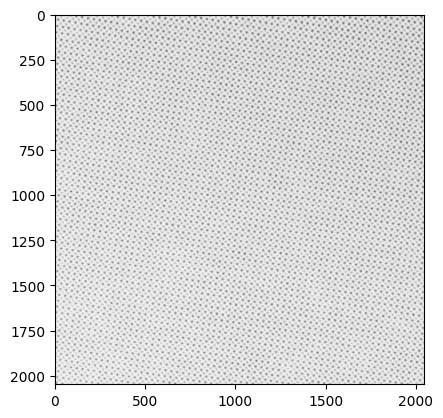

In [172]:
plt.imshow(haadfs[:,:,0], cmap="binary")

In [173]:
# Rotate and normalize images for scanning_drift_corr
haadfs = array([rot90(haadfs[:, :, i], -(a//90)) for i, a in enumerate(scanAngles)])
haadfs = so.image_norm(haadfs[:num_frames_to_use])
if dpc_found:
    dpc_ac = array([so.fast_rotate_90deg(dpc_ac[:, :, i], -ang)
                    for i, ang in enumerate(scanAngles)])
    dpc_bd = array([so.fast_rotate_90deg(dpc_bd[:, :, i], -ang)
                    for i, ang in enumerate(scanAngles)])
    dpc_ac = so.image_norm(dpc_ac)
    dpc_bd = so.image_norm(dpc_bd)
    dpc_mag = (dpc_ac**2 + dpc_bd**2)**0.5

# Extract microscope parameters from the metadata
pixel_size = float(metadata['Pixel Size [nm]'][0])/1e-9
conv_angle = float(metadata['Convergence Semi-angle [mrad]'])*1e-3

KeyError: 'Pixel Size [nm]'

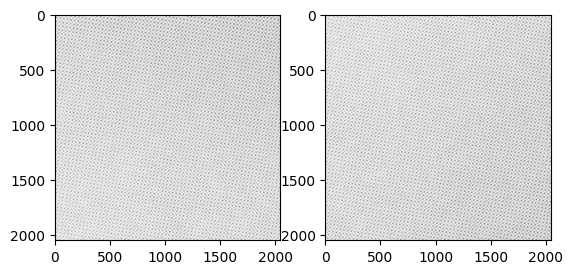

In [174]:
# Optionally display the first two images in the series to check that they look right
fig, axs = plt.subplots(1, 2)
axs[0].imshow(haadfs[0], cmap="binary")
axs[1].imshow(haadfs[1], cmap="binary")
plt.show()

if dpc_found:
    fig, axs = plt.subplots(1, 2)
    # noinspection PyUnboundLocalVariable
    axs[0].imshow(dpc_mag[0, :, :], cmap="binary")
    axs[1].imshow(dpc_mag[1, :,:], cmap="binary")

Now we will actually run the drift correction algorithm.  It happens in 3 steps:
1. An initial linear drift correction step (based on cross or phase correlation)
2. A nonlinear refinement step that involves iteratively shifting individual fast-scan lines (global alignment checked via cross or phase correlation)
3. A merge step, where the rotated frames are combined in Fourier space to form a final corrected image, and the result is masked to only the coherent region

Each step gets its own cell, since it me be desirable to run the same step multiple times with different parameters to find the best fit.  In addition, there is an optional step between steps 1 and 2 to correct scan vector distortion, but this requires a reference image collected during the same microscope session (or at least close enough in time); usually Si 110 is preferred.  If such a reference isn't available, this step can be skipped.  If it is, correct that reference image using the normal three steps, and then save to a `.npy` file.

Note: Depending on the image, it may be better to correct the HAADF image first and then apply the correciton to the DPC component images. Alternatively, the dpc magnitude can be used. Pass the desired image to `SPmerge01linear`.


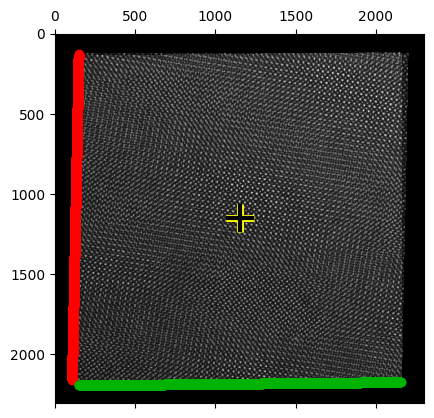

In [175]:
sm = SPmerge01linear(scanAngles, haadfs, niter=1)

In [20]:
# Optional scan vector distortion calibration step
svd_path = graphical.gui_get_path()
calibration = load(svd_path)
sm = SPcalibration(sm, calibration)  # TODO: extract this method from the script Steve sent me
grd = 'GRD'  # Added to filename since scan calibration completed

PermissionError: [Errno 13] Permission denied: '.'

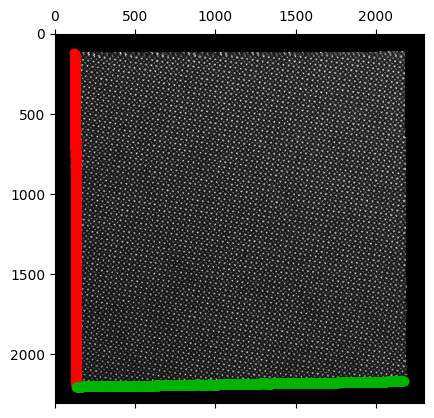

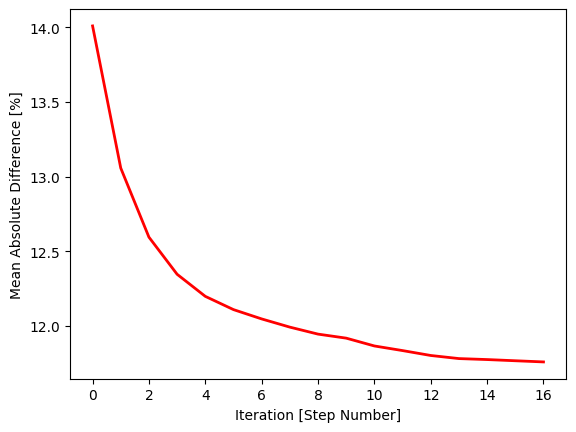

In [176]:
sm2 = SPmerge02(sm, 16, 8, flagGlobalShift=True, stepSizeReduce=0.5)

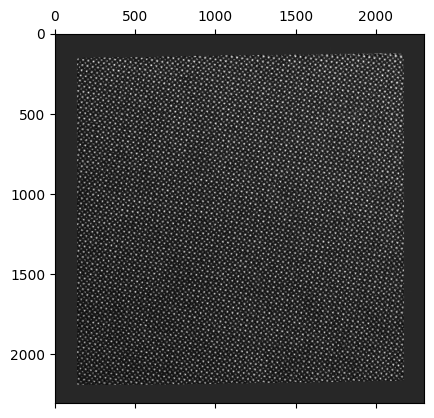

In [177]:
haadf_drift_corr, _, _ = SPmerge03(sm2, KDEsigma=0.5)

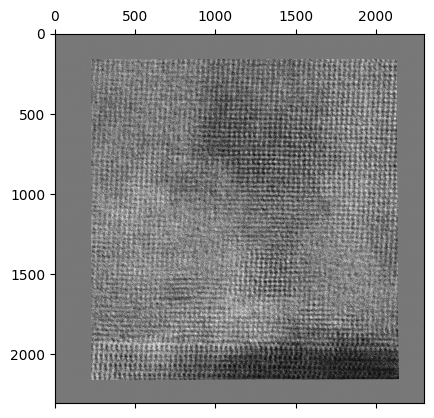

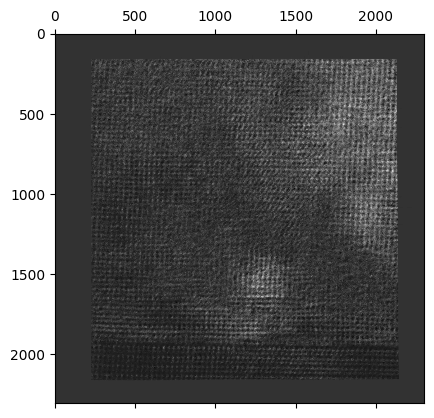

In [163]:
# Apply correction to DPC components, if present
if dpc_found:
    sigma = 0.5

    sm_ac = deepcopy(sm2)
    # noinspection PyUnboundLocalVariable
    sm_ac.scanLines = dpc_ac
    imageFinal_ac, _, _ = SPmerge03(sm_ac, KDEsigma=sigma)

    sm_bd = deepcopy(sm2)
    # noinspection PyUnboundLocalVariable
    sm_bd.scanLines = dpc_bd
    imageFinal_bd, _, _ = SPmerge03(sm_bd, KDEsigma=sigma)

In [99]:
# Crop DPC images, if present
if dpc_found:
    # noinspection PyUnboundLocalVariable
    CoMxy = stack([imageFinal_ac, imageFinal_bd])[:, 250:-250, 250:-250]

    phase = so.get_phase_from_com(CoMxy, theta=-132, flip=True,
                                   high_low_filter=False,
                                   filter_params={'beam_energy': 200e3,
                                                  'conv_semi_angle': conv_angle,
                                                  'pixel_size': pixel_size,
                                                  'high_pass': 0.05,
                                                  'low_pass': 0.85,
                                                  'edge_smoothing': 0.02})
    phase = -1*so.image_norm(phase[0])

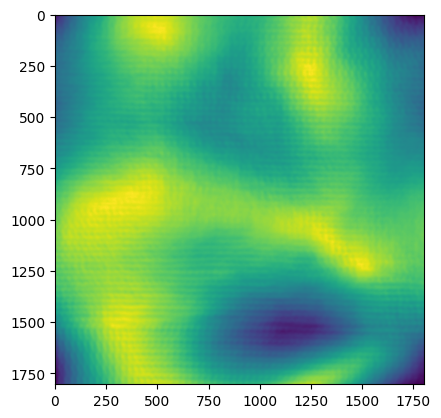

In [100]:
plt.imshow(phase)

In [164]:
graphical.gui_savetiff((haadf_drift_corr*(2**16-1)).astype(uint16),
                       default_fname=f"{filepath.stem}_dcorr_HAADF_{grd}.tif")
if dpc_found:
    # noinspection PyUnboundLocalVariable
    graphical.gui_savetiff((so.image_norm(imageFinal_ac)*(2**16-1)).astype(uint16),
                           default_fname=f"{filepath.stem}_dcorr_DPC_AC_{grd}.tif")
    graphical.gui_savetiff((so.image_norm(imageFinal_bd)*(2**16-1)).astype(uint16),
                           default_fname=f"{filepath.stem}_dcorr_DPC_BD_{grd}.tif")